# let's try to implement a conv decoder

this uses all the heads of the ijepa encoder

## part 1: stat the dataset

In [1]:
import h5py
from matplotlib import pyplot as plt
import einops
import math

In [2]:
fp = h5py.File('voc_projection.h5', 'r')
fp.keys()

<KeysViewHDF5 ['train.encodings', 'train.features', 'train.labels', 'trainval.encodings', 'trainval.features', 'trainval.labels', 'val.encodings', 'val.features', 'val.labels']>

In [3]:
train_encodings = fp['train.encodings']
train_features  = fp['train.features']
train_labels    = fp['train.labels']

print('train labels:   ', train_labels.shape)
print('train features: ', train_features.shape)
print('train encodings:', train_encodings.shape)

train labels:    (1464, 224, 224)
train features:  (1464, 3, 224, 224)
train encodings: (1464, 256, 1280)


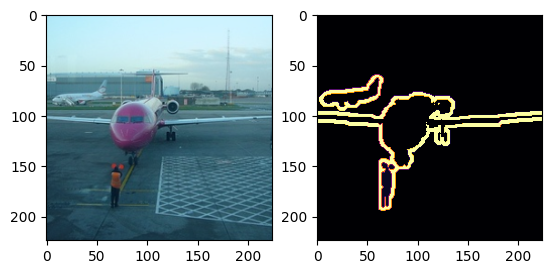

In [4]:
fig, (ax_img, ax_lbl) = plt.subplots(1, 2)

image = einops.rearrange(train_features[0], 'c h w -> h w c')
image = (image + abs(image.min())) / abs(image.max() - image.min()) # undo the preprocessing for display

ax_img.imshow(image)
ax_lbl.imshow(train_labels[0], cmap='inferno')
plt.show()

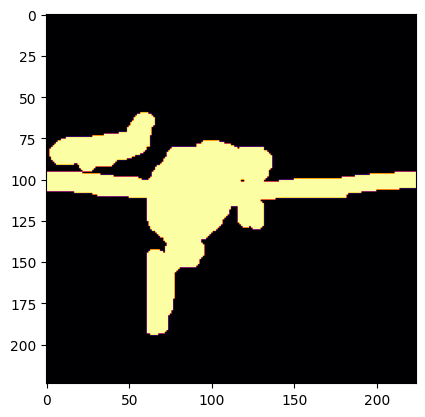

In [5]:
y_test = train_labels[0].copy()
y_test[y_test > 0] = 1.0
plt.imshow(y_test, cmap='inferno')

## part 2: a dataset loader

(repeating imports for easier splitting into files)

In [6]:
import h5py
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.transforms import Compose
from typing import Any
import numpy as np
import einops

class ToTensor:
    '''Convert ndarrays to tensors.'''

    def __call__(self, arr):
        return torch.from_numpy(arr)

    
class ScaleToUnit:
    '''convert a label to 0-1 from 0-255'''
    def __call__(self, label):
        # this was dumb:
        # return (label + abs(label.min())) / abs(label.max() - label.min())
        return label / 255.0
    
class OneHotTwoClassLabelMatrix:
    '''Convert label ndarrays (NxM) to (NxMx2) one-hot encoded vectors'''

    def __call__(self, label):
        # assumes noclass is 0 and class is 1
        return np.stack(
            [
                1 - label,
                label
            ],
            axis=2
        )

class PredictEntireObject:
    '''Modify the label to fill in the label'''

    def __call__(self, label):
        # assumes noclass is 0 and class is 1
        label[label > 0] = 1.0
        return label
    
    
class VOCProjectedDataset(Dataset):
    projection_dataset_file: Path
    projection_split: str
    dataset_handle: Any
    transform: Any
    target_transform: Any
    
    labels: np.ndarray
    encodings: np.ndarray

    def __init__(self, projection_set: Path, split: str = 'training', transform=None, target_transform=None):
        '''
        Load a dataset from the voc projected h5 file
        '''
        if type(projection_set) is str:
            projection_set = Path(projection_set)
        assert projection_set.exists()

        # save the transform & dataset info
        self.transform = transform
        self.target_transform = target_transform
        self.projection_dataset_file = projection_set
        self.projection_split = split

        # open the dataset and do some sanity checks
        self.dataset_handle = h5py.File(self.projection_dataset_file, 'r')

        # i regret not using h5's groups for this
        # c'est la vie
        assert f'{split}.encodings' in self.dataset_handle
        assert f'{split}.labels' in self.dataset_handle
        assert self.dataset_handle[f'{split}.encodings'].shape[0] == self.dataset_handle[f'{split}.labels'].shape[0]
        
        self.labels = self.dataset_handle[f'{split}.labels']
        self.encodings = self.dataset_handle[f'{split}.encodings']
        
    def __len__(self):
        return self.labels.shape[0]


    def __getitem__(self, index):
        X = self.encodings[index]
        y = self.labels[index]
        
        if self.transform:
            X = self.transform(X)
        
        if self.target_transform:
            y = self.target_transform(y)
            
        return X, y
    

dataset = VOCProjectedDataset(
    'voc_projection.h5',
    split='train',
    transform=ToTensor(),
    target_transform=Compose([
        ScaleToUnit(),
        OneHotTwoClassLabelMatrix(),
        ToTensor()
    ])
)
print(f'voc dataset on {dataset.projection_split} contains {len(dataset)} elements')


voc dataset on train contains 1464 elements


## part 3: a really simple decoder

In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvolutionalDecoder(nn.Module):
    def __init__(self):
        super(ConvolutionalDecoder, self).__init__()
    
        # ngl this is a super big guess
        self.conv1 = nn.ConvTranspose2d(1280, 256, kernel_size=11, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.ConvTranspose2d(256, 1, kernel_size=9, stride=6, padding=3, output_padding=5)
        self.bn2 = nn.BatchNorm2d(1)
    
    def forward(self, x):
        # first, convert the (batch) x 256 (heads) x 1280 (head depth) latent rep to Bx1280x16x16
        x = einops.rearrange(x, 'b (h1 h2) d -> b d h1 h2', h1 = 16)
        
        # conv block 1 : 1280x16x16 -> 256x37x37
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        # conv block 2 :  256x37x37 -> 2x224x224
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.sigmoid(x)
        
        return x

In [8]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# import torch
# from torch import nn

# class ConvolutionalDecoder(nn.Module):
#     def __init__(self):
#         super(ConvolutionalDecoder, self).__init__()
#         self.decoder = nn.Sequential(
#             # Begin with a linear layer to map latent vector to a spatial structure
#             nn.Linear(1280, 256 * 7 * 7),  # Adjust size according to desired feature map size
#             nn.ReLU(),
#             nn.Unflatten(1, (256, 7, 7)),  # Reshape to (batch_size, channels, height, width)
            
#             # Transposed convolutional layers
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 14, 14)
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 28, 28)
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 56, 56)
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # Output: (16, 112, 112)
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 224, 224)
#             nn.Sigmoid()  # Assuming output pixel values are to be between 0 and 1
#         )

#     def forward(self, x):
#         x = x[:,-1,:] # get the last head's rep
#         return self.decoder(x)

# # Example usage
# decoder = ConvolutionalDecoder()
# latent_vector = torch.randn(8, 256, 1280)  # Simulate a batch of size 1
# output_image = decoder(latent_vector)
# print(output_image.shape)  # Should be torch.Size([1, 1, 224, 224])

    
# model = LinearConvolutionalDecoder()
# model(torch.rand(8,256,1280))

# part the fourth: can we actually get this thing to train?

In [9]:
%%time

# hyperparams
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 100
FINAL_MODEL_CKPT = './checkpoints/decoder_fullobj_epoch100.pth'
FINAL_MODEL_METRICS = './checkpoints/decoder_fullobj_metrics.npy'

# setup
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
import einops
from torchmetrics import JaccardIndex
import statistics
from pathlib import Path

def train():
    dataset_train = VOCProjectedDataset(
        'voc_projection.h5',
        split='train',
        transform=ToTensor(),
        target_transform=Compose([
            ScaleToUnit(),
            PredictEntireObject(),
            # OneHotTwoClassLabelMatrix(),
            ToTensor()
        ])
    )
    dataset_val = VOCProjectedDataset(
        'voc_projection.h5',
        split='trainval',
        transform=ToTensor(),
        target_transform=Compose([
            ScaleToUnit(),
            PredictEntireObject(),
            # OneHotTwoClassLabelMatrix(),
            ToTensor()
        ])
    )

    dl_train = DataLoader(
        dataset_train,
        pin_memory=True,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=12
    )
    dl_val = DataLoader(
        dataset_val,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=False,
        num_workers=12
    )

    device = 'cuda'
    # device = 'cpu'

    model = ConvolutionalDecoder().to(device)

    # loss_fn = torch.nn.BCELoss()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE
    )


    # we're gonna make a metrics matrix
    # EPOCH x (trn loss, trn jac, tst jac)
    metrics = np.zeros((EPOCHS, 3))


    # pbar = trange(EPOCHS, desc='epoch')
    for epoch in range(EPOCHS):
        # print(f'training epoch {epoch}/{EPOCHS}...')

        model.train()
        avg_trn_loss = []
        avg_trn_jaccard = []
        jaccard = JaccardIndex(
            task='binary'
        ).to(device)
        for X, y in tqdm(dl_train, desc='train'):

            # running into some weird numerical issue with CUDA... this didn't fix it.
            # X = torch.clamp(X, min=0, max=1)
            # y = torch.clamp(y, min=0, max=1)

            X = X.to(device)

            # y = einops.rearrange(y, 'b h w c -> b c h w')
            y = y.to(device)


            output = model(X)
            # output = output

            loss = loss_fn(output.squeeze(), y)
            loss.backward()
            optimizer.step()

            loss_val = loss.item()
            # print(loss_val)
            with torch.no_grad():
                # print('output shape', output.shape)
                # print('y shape', y.shape)

                # okay, here we're going to do something cursed
                # we'll clamp everything > 0 

                y_jac = y.clone().detach()
                y_jac[y_jac > 0.5] = 1
                y_jac[y_jac != 1]  = 0

                out_jac = output.clone().detach()

                jaccard_val = jaccard(out_jac.flatten(), y_jac.flatten())
                jaccard_val = jaccard_val.cpu().numpy() # unwrap the 0-dim tensor
                jaccard_val = float(jaccard_val)

                avg_trn_loss.append(loss_val)
            avg_trn_jaccard.append(jaccard_val)

        avg_trn_loss = statistics.mean(avg_trn_loss)
        avg_trn_jaccard = statistics.mean(avg_trn_jaccard)
        # avg_trn_jaccard = None


        # break

        avg_tst_jaccard = []

        model.eval()
        with torch.no_grad():
            for X, y in tqdm(dl_val, desc='val'):
                X = X.to(device)
                y = y.to(device)

                output = model(X)
                y_jac = y.clone().detach()
                y_jac[y_jac > 0.5] = 1
                y_jac[y_jac != 1]  = 0

                out_jac = output.clone().detach()

                jaccard_val = jaccard(out_jac.flatten(), y_jac.flatten())
                jaccard_val = jaccard_val.cpu().numpy() # unwrap the 0-dim tensor
                jaccard_val = float(jaccard_val)

                avg_tst_jaccard.append(jaccard_val)

        avg_tst_jaccard = statistics.mean(avg_tst_jaccard)


        print(f'epoch {epoch}: train loss {avg_trn_loss:0.4}, train jaccard: {avg_trn_jaccard:0.4}, test jaccard: {avg_tst_jaccard:0.4}')

        metrics[epoch] = (avg_trn_loss, avg_trn_jaccard, avg_tst_jaccard)

        torch.save(
            model.state_dict(),
            f'./checkpoints/decoder_fullobj_epoch{epoch}.pth'
        )
    
    return model, metrics

if Path(FINAL_MODEL_CKPT).exists():
    model = ConvolutionalDecoder()
    model.load_state_dict(
        torch.load(FINAL_MODEL_CKPT)
    )
    metrics = np.load(FINAL_MODEL_METRICS)
    print(f'loaded model from checkpoint ({FINAL_MODEL_CKPT})')
    
else:
    print(f'no model checkpoint found, beginning train...')
    model, metrics = train()
    np.save(FINAL_MODEL_METRICS, metrics)


no model checkpoint found, beginning train...


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.79it/s]


epoch 12: train loss 468.9, train jaccard: 0.6458, test jaccard: 0.653


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.64it/s]


epoch 13: train loss 468.6, train jaccard: 0.6484, test jaccard: 0.6565


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.48it/s]


epoch 14: train loss 468.4, train jaccard: 0.6538, test jaccard: 0.6603


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 26.29it/s]


epoch 15: train loss 468.1, train jaccard: 0.6588, test jaccard: 0.6637


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.70it/s]


epoch 16: train loss 467.6, train jaccard: 0.6692, test jaccard: 0.6748


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.73it/s]


epoch 17: train loss 467.5, train jaccard: 0.6725, test jaccard: 0.6783


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.76it/s]


epoch 18: train loss 467.0, train jaccard: 0.6724, test jaccard: 0.6713


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.36it/s]


epoch 19: train loss 467.2, train jaccard: 0.6697, test jaccard: 0.6736


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.69it/s]


epoch 20: train loss 467.3, train jaccard: 0.6694, test jaccard: 0.6741


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.47it/s]


epoch 21: train loss 466.9, train jaccard: 0.6705, test jaccard: 0.6743


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.79it/s]


epoch 22: train loss 467.0, train jaccard: 0.674, test jaccard: 0.6775


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.53it/s]


epoch 23: train loss 466.9, train jaccard: 0.6857, test jaccard: 0.6882


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.03it/s]


epoch 24: train loss 466.7, train jaccard: 0.691, test jaccard: 0.6942


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.59it/s]


epoch 25: train loss 466.6, train jaccard: 0.6947, test jaccard: 0.6943


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.35it/s]


epoch 26: train loss 466.5, train jaccard: 0.6981, test jaccard: 0.6991


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.86it/s]


epoch 27: train loss 465.9, train jaccard: 0.7021, test jaccard: 0.7012


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.94it/s]


epoch 28: train loss 466.2, train jaccard: 0.7054, test jaccard: 0.705


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.76it/s]


epoch 29: train loss 466.6, train jaccard: 0.7066, test jaccard: 0.7068


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.78it/s]


epoch 30: train loss 466.0, train jaccard: 0.709, test jaccard: 0.7073


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.94it/s]


epoch 31: train loss 466.1, train jaccard: 0.7106, test jaccard: 0.7093


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.18it/s]


epoch 32: train loss 465.9, train jaccard: 0.7112, test jaccard: 0.709


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.33it/s]


epoch 33: train loss 465.7, train jaccard: 0.7119, test jaccard: 0.7062


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.54it/s]


epoch 34: train loss 465.8, train jaccard: 0.7115, test jaccard: 0.707


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.32it/s]


epoch 35: train loss 465.7, train jaccard: 0.711, test jaccard: 0.7045


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.49it/s]


epoch 36: train loss 465.8, train jaccard: 0.7098, test jaccard: 0.7086


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.64it/s]


epoch 37: train loss 465.1, train jaccard: 0.714, test jaccard: 0.7072


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.59it/s]


epoch 38: train loss 464.6, train jaccard: 0.7142, test jaccard: 0.7109


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.23it/s]


epoch 39: train loss 465.5, train jaccard: 0.7173, test jaccard: 0.7154


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.19it/s]


epoch 40: train loss 464.9, train jaccard: 0.722, test jaccard: 0.7168


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 26.09it/s]


epoch 41: train loss 465.6, train jaccard: 0.7252, test jaccard: 0.7194


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.45it/s]


epoch 42: train loss 465.5, train jaccard: 0.7289, test jaccard: 0.7225


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.48it/s]


epoch 43: train loss 464.9, train jaccard: 0.7293, test jaccard: 0.7228


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.52it/s]


epoch 44: train loss 464.8, train jaccard: 0.7314, test jaccard: 0.7256


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.35it/s]


epoch 45: train loss 463.9, train jaccard: 0.7323, test jaccard: 0.7233


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.43it/s]


epoch 46: train loss 465.1, train jaccard: 0.7356, test jaccard: 0.7283


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.12it/s]


epoch 47: train loss 464.7, train jaccard: 0.7401, test jaccard: 0.729


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.67it/s]


epoch 48: train loss 464.0, train jaccard: 0.7364, test jaccard: 0.7273


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.70it/s]


epoch 49: train loss 464.8, train jaccard: 0.7392, test jaccard: 0.7269


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.47it/s]


epoch 50: train loss 464.5, train jaccard: 0.7379, test jaccard: 0.7262


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.51it/s]


epoch 51: train loss 464.4, train jaccard: 0.7407, test jaccard: 0.7265


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.88it/s]


epoch 52: train loss 463.9, train jaccard: 0.7398, test jaccard: 0.7275


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.90it/s]


epoch 53: train loss 464.4, train jaccard: 0.7427, test jaccard: 0.7294


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.36it/s]


epoch 54: train loss 464.2, train jaccard: 0.7446, test jaccard: 0.7326


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.37it/s]


epoch 55: train loss 463.6, train jaccard: 0.7467, test jaccard: 0.7322


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.50it/s]


epoch 56: train loss 464.6, train jaccard: 0.7481, test jaccard: 0.7365


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.84it/s]


epoch 57: train loss 464.6, train jaccard: 0.7514, test jaccard: 0.737


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.73it/s]


epoch 58: train loss 463.6, train jaccard: 0.7511, test jaccard: 0.7353


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.40it/s]


epoch 59: train loss 464.3, train jaccard: 0.7514, test jaccard: 0.7327


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 26.04it/s]


epoch 60: train loss 463.5, train jaccard: 0.7534, test jaccard: 0.7374


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.62it/s]


epoch 61: train loss 463.5, train jaccard: 0.7542, test jaccard: 0.7383


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.43it/s]


epoch 62: train loss 463.4, train jaccard: 0.7571, test jaccard: 0.7402


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.52it/s]


epoch 63: train loss 464.0, train jaccard: 0.7589, test jaccard: 0.7405


val: 100%|█████████████████████████████████| 92/92 [00:03<00:00, 25.30it/s]


epoch 64: train loss 463.8, train jaccard: 0.7579, test jaccard: 0.7416


train:  72%|██████████████████████▏        | 33/46 [00:02<00:00, 16.68it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



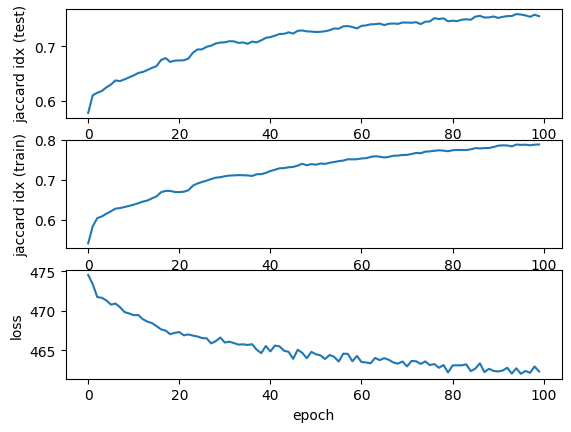

In [10]:
fig, (ax_jac_tst, ax_jac_trn, ax_loss) = plt.subplots(3)

# jaccard axis (tst)
ax_jac_tst.set_xlabel('epoch')
ax_jac_tst.set_ylabel('jaccard idx (test)')
ax_jac_tst.plot(np.arange(0,metrics.shape[0]), metrics[:,2])

# jaccard axis (trn)
ax_jac_trn.set_xlabel('epoch')
ax_jac_trn.set_ylabel('jaccard idx (train)')
ax_jac_trn.plot(np.arange(0,metrics.shape[0]), metrics[:,1])

# loss (trn)
ax_loss.set_xlabel('epoch')
ax_loss.set_ylabel('loss')
ax_loss.plot(np.arange(0,metrics.shape[0]), metrics[:,0])

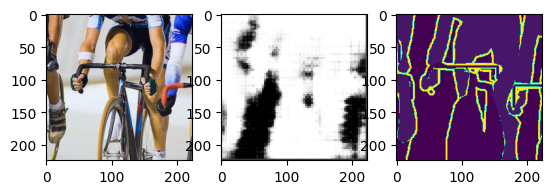

In [12]:
def show_val_sample(index):
    dataset_trnval = VOCProjectedDataset(
        'voc_projection.h5',
        split='val',
        transform=ToTensor(),
        target_transform=Compose([
            ScaleToUnit(),
            # OneHotTwoClassLabelMatrix(),
            ToTensor()
        ])
    )



    def create_pred(model, feature_pair, device = 'cuda'):
        X, y = feature_pair

        model = model.to(device)
        X, y = X.to(device), y.to(device)

        model.eval()
        with torch.no_grad():
            output = model([X])

        return output.cpu().numpy()


    X, y = dataset_trnval[index]
    feat = dataset_trnval.dataset_handle['val.features'][index]
    output = create_pred(model, (X,y))[0,0,:,:]

    fig, (ax_feat, ax_pred, ax_true) = plt.subplots(1,3)

    X_image = einops.rearrange(feat, 'c h w -> h w c')
    X_image = (X_image + abs(X_image.min())) / abs(X_image.max() - X_image.min()) # undo the preprocessing for display

    ax_feat.imshow(X_image)
    ax_pred.imshow(output, cmap='gray')
    ax_true.imshow(y)
        
show_val_sample(4)